# Global settings

Relative to the root directory, ensure that the R codes (*.R) are "Rcode/" and the data files (*.csv) are in "data/"

In [1]:
rootDir <- "./" # directory containing notebook, Rcode, and data directories

In [38]:
setwd(paste(rootDir, "Rcode", sep=""))
conv <- pi/180 
source("general_functions.R")
source("distance_functions.R")
setwd("../")
library(MASS) # for truehist
library(fields) # for image.plot
library(RColorBrewer) # for colorRampPalette
mypalette <- colorRampPalette(brewer.pal(9, "Greys"), space="rgb", interpolate="linear", bias=2.5)
mycols <- mypalette(64)

## Distance posteriors using simulated data

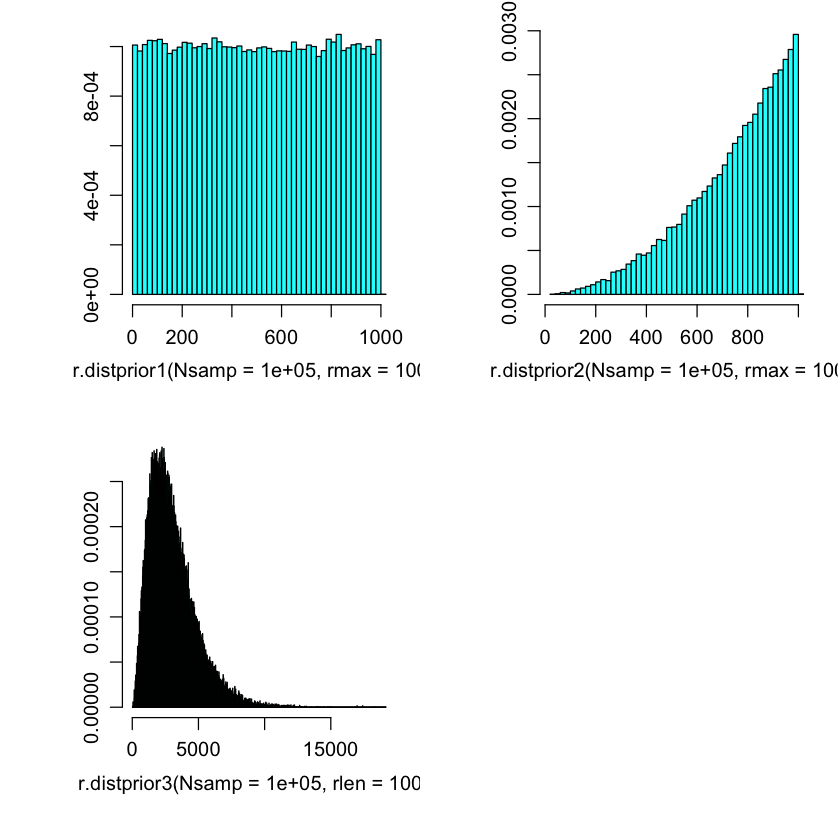

In [39]:
# Plot the posteriors to get feel for what they look like
par(mfrow=c(2,2), mar=c(5,5,0.5,1), oma=c(0.1,0.1,0.5,0.1), mgp=c(2.2,0.8,0), cex=1.0) 
# Draw from distance priors (as a check of the code) and plot 
# 1,2,3 are uniform in distance, uniform in space density, and exponentially decreasing space density, respectively.
truehist(r.distprior1(Nsamp=1e5, rmax=1e3), h=20)
truehist(r.distprior2(Nsamp=1e5, rmax=1e3), h=20)
truehist(r.distprior3(Nsamp=1e5, rlen=1e3), h=20)

[1] -3678.039-32485.32i -3678.039+32485.32i  9356.077+    0.00i

mode        lo        hi        5%       50%       95% 
 9356.077  8478.274 10420.195  8256.173  9486.594 11110.109

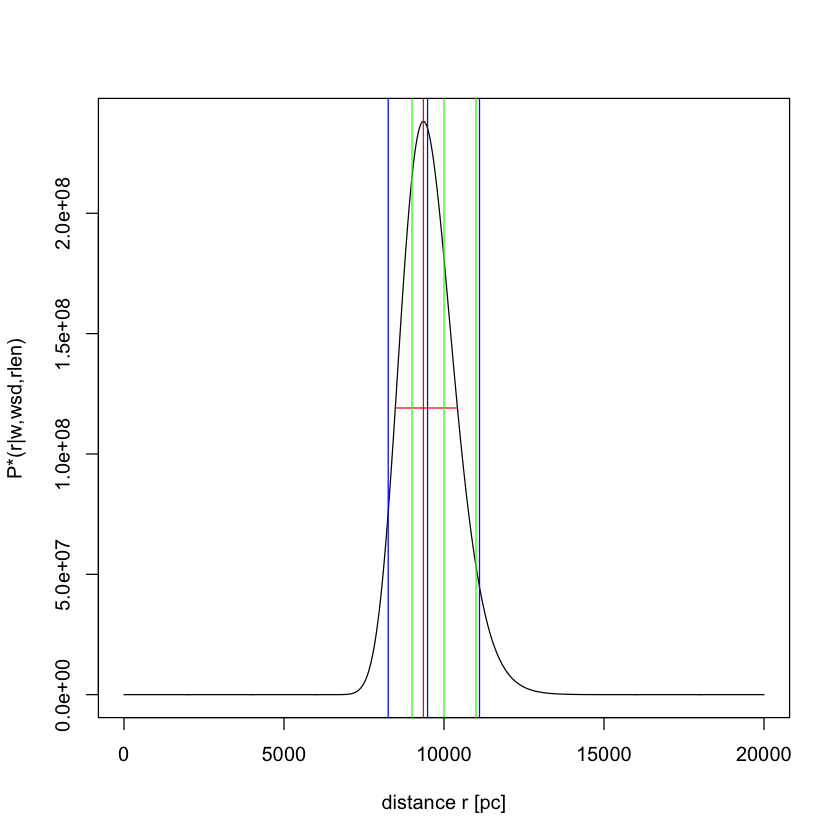

In [40]:
# Plot unnormalized posteriors over distance for some parallax measurement
# and overplot mode (red), quantiles (blue), 
# and naive parallax inversion and first order uncertainty propagation (green)
w    <- 1e-4
wsd  <- 1e-5
rlen <- 1e3
r <- seq(from=0, to=2e4, length.out=1e3)
plot(r, ud.distpost3(r, w, wsd, rlen), type="l", xlab="distance r [pc]", ylab="P*(r|w,wsd,rlen)")
mode.distpost3(w, wsd, rlen, retall=TRUE)
rMode  <- mode.distpost3(w, wsd, rlen)
rFWHM  <- fwhm.distpost3(w, wsd, rMode=rMode, rlen, rmax=1e6) 
rQuant <- quantiles.distpost3(w, wsd, rlen, probs=c(0.05, 0.5, 0.95), Nsamp=1e5)
abline(v=c(rMode, rQuant), col=c("red", rep.int("blue", length(rQuant))))
M <- ud.distpost3(r=rMode, w, wsd, rlen)
lines(x=c(rFWHM), y=c(M,M)/2, col="red")
abline(v=c(1/w, (1/w)+c(+1,-1)*wsd/w^2), col="green")
c(mode=rMode, rFWHM, rQuant)

## Read and check GDR1 data

In [41]:
# parallaxes are in mas, angles in degrees
dat <- read.csv(paste(rootDir, "data/gdr1set01.csv", sep=""), sep=",")
# convert parallaxes to arcsec so that distances come out as pc
dat$parallax <- 1e-3*dat$parallax
dat$parallax_error <- 1e-3*dat$parallax_error

In [42]:
dim(dat)
# To reduce data size for testing purposes
dat <- dat[1:10,]
dat

[1] 6908    4

parallax,parallax_error,l,b
0.0003544360,0.0009808290,175.2932,-4.994473
0.0017235501,0.0002843546,175.1683,-4.150353
0.0004696314,0.0003569680,175.1830,-4.193350
0.0013279830,0.0004677145,175.1697,-4.573416
0.0016021144,0.0002714283,175.0998,-4.030721
0.0038513590,0.0002324245,175.0159,-3.711086
0.0011199443,0.0003135849,175.1362,-4.367051
0.0003205481,0.0002506443,175.0811,-4.690289
0.0016388455,0.0003956992,175.0806,-4.610517
0.0013188627,0.0002670727,175.1550,-4.655140


In [43]:
apply(dat, 2, range)

parallax,parallax_error,l,b
0.0003205481,0.0002324245,175.0159,-4.994473
0.0038513590,0.0009808290,175.2932,-3.711086


## Distance posteriors for GDR1

In [44]:
rMode  <- Vectorize(mode.distpost3, c("w", "wsd"))(w=dat$parallax, wsd=dat$parallax_error, rlen)
rMode

[1] 2065.3055  604.0960 2060.1100  899.7459  650.4302  261.3139  978.8059
 [8] 2502.6507  666.8227  799.7472

In [45]:
# The root-finding algorithm in fwhm.distpost3 may give warnings
rFWHM <- Vectorize(fwhm.distpost3, c("w", "wsd", "rMode"))(w=dat$parallax, wsd=dat$parallax_error, rMode=rMode, rlen=rlen, rmax=1e6)
rFWHM <- t(rFWHM)
cbind(rMode, rFWHM)

rMode,lo,hi
2065.3055,944.4383,4161.7413
604.0960,501.5076,759.5778
2060.1100,1217.7406,3819.4863
899.7459,595.9186,1722.0357
650.4302,537.4952,823.4606
261.3139,243.8314,281.5017
978.8059,717.3162,1517.5688
2502.6507,1593.9393,4244.6950
666.8227,505.9770,976.9305
799.7472,637.7348,1070.7340


In [46]:
# My code for computing the quantiles computes the normalization using MCMC, which is very slow.
# A grid would be faster, but its size/spacing would generally need to be optimized for every source separately.
rQuant <- Vectorize(quantiles.distpost3, c("w", "wsd"))(w=dat$parallax, wsd=dat$parallax_error, rlen, probs=c(0.05, 0.5, 0.95), Nsamp=1e5)
rQuant <- t(rQuant)

In [18]:
cbind(w=dat$parallax, fobs=dat$parallax_error/dat$parallax, rMode, rFWHM, rQuant)

w,fobs,rMode,lo,hi,5%,50%,95%
0.0003544360,2.76729539,2065.3055,944.4383,4161.7413,1050.8761,2792.5232,6349.8678
0.0017235501,0.16498195,604.0960,501.5076,759.5778,492.7520,646.0906,947.1072
0.0004696314,0.76010247,2060.1100,1217.7406,3819.4863,1292.0253,2735.3137,6046.4990
0.0013279830,0.35219917,899.7459,595.9186,1722.0357,651.1014,1417.0939,4173.6395
0.0016021144,0.16941877,650.4302,537.4952,823.4606,527.6501,701.7220,1047.5205
0.0038513590,0.06034871,261.3139,243.8314,281.5017,239.2193,263.3627,293.0670
0.0011199443,0.28000044,978.8059,717.3162,1517.5688,735.0831,1248.2245,3025.2562
0.0003205481,0.78192412,2502.6507,1593.9393,4244.6950,1631.1577,3135.1966,6377.7973
0.0016388455,0.24144996,666.8227,505.9770,976.9305,511.0290,813.9668,1978.3901
0.0013188627,0.20250230,799.7472,637.7348,1070.7340,631.5897,890.2663,1527.1139


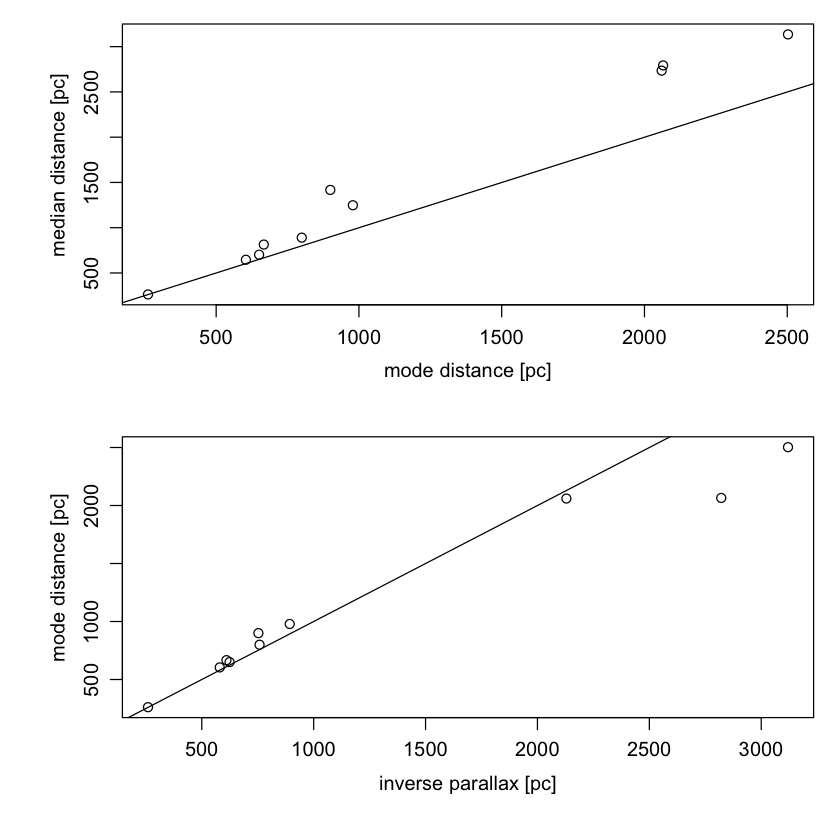

In [19]:
par(mfrow=c(2,1), mar=c(5,5,0.5,1), oma=c(0.1,0.1,0.5,0.1), mgp=c(2.2,0.8,0), cex=1.0) 
plot(rMode, rQuant[,2], xlab="mode distance [pc]", ylab="median distance [pc]")
abline(a=0, b=1)
plot(1/dat$parallax, rMode, xlab="inverse parallax [pc]", ylab="mode distance [pc]")
abline(a=0, b=1)

## Distance posterior with a hierarchical model for simulated data

In [20]:
# Use exponentially decreasing space density prior, but marginalize over length scale parameter, rlen. 
# To do this adopt a hyperprior P(rlen), with non-explicit hyperparameters. The new posterior is
# P(r|w) = int P(r,rlen|w) d(rlen)
# P*(r|w) = int P(w|r)P(r|rlen)P(rlen)
# Define the above integrand (to within normalization factor 1/P(w)) as a function, whereby first argument is rlen:
# - hyperprior is a scaled/shifted beta function (defined over rlenRange) with hard-coded hyperparameters.
# - lower limit (min(rlenRange)) should be >0, otherwise prior P(r|rlen) evaluates to NaN (prior undefined)
# This function is P*(r|w), and "hier" in name indicates it is from a "hierarchical" model
ud.distpost3hier <- function(rlen, r, w, wsd, rlenRange) {
  d.like(w=w, r=r, wsd=wsd)*d.distprior3(r=r, rlen=rlen)*d.betagen(x=rlen, xrange=rlenRange, shape1=1, shape2=1) 
}
# Test integration using this integrand
w <- 5e-3
wsd <- 1e-3
r <- 4e2
rlenRange <- c(1e1, 1e3)
integrate.func(f=ud.distpost3hier, lower=rlenRange[1], upper=rlenRange[2], r=r, w=w, wsd=wsd, 
               rlenRange=rlenRange, subdivisions=1e3, rel.tol=1e-6, abs.tol=1e-6) 

[1] 0.008307778

Posterior mean, SD for r = 234.685 69.65924 kpc


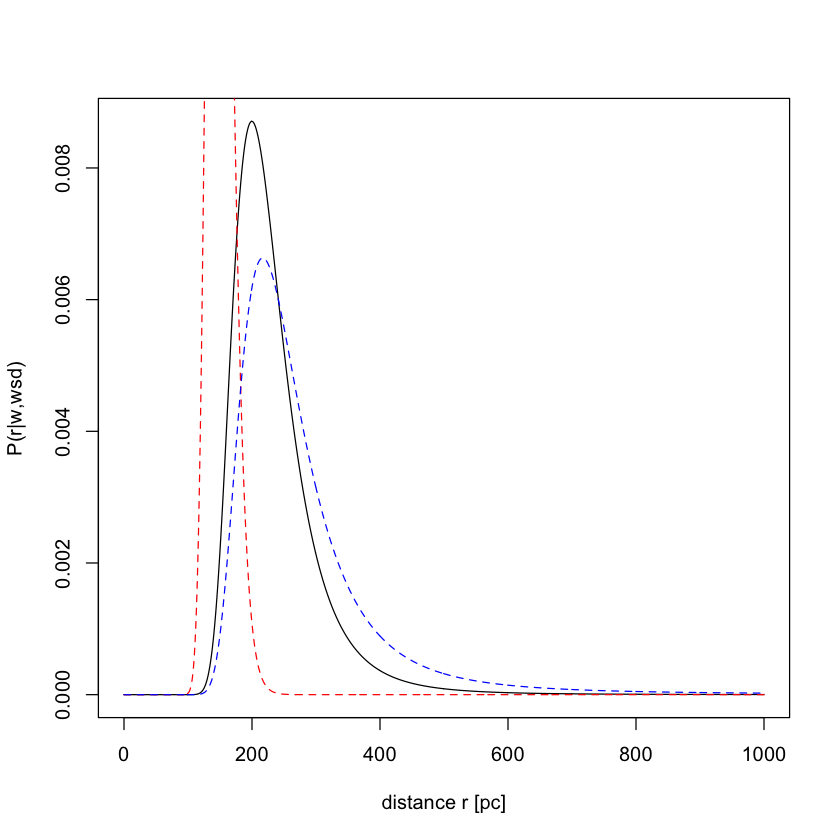

In [21]:
# Compute P*(r|w) on a grid
r <- seq(from=0, to=1e3, length.out=1e3)
udDistpost3hier <- double(length=length(r))
for(i in 1:length(r)) {
    udDistpost3hier[i] <- integrate.func(f=ud.distpost3hier, lower=rlenRange[1], upper=rlenRange[2], r=r[i], 
                                         w=w, wsd=wsd, rlenRange=rlenRange, 
                                         subdivisions=1e3, rel.tol=1e-6, abs.tol=1e-6) 
}
# TODO: Some integrals don't converge so return NA. Just set to zero for now
udDistpost3hier[is.na(udDistpost3hier)] <- 0
# Plot and overplot what we get with two different fixed values of rlen
# Scale plots to have maximum of 1 (would be better to normalize them)
mom <- pdfmom(udDistpost3hier, r)
cat("Posterior mean, SD for r =", mom$mean, mom$sd, "kpc\n")
udDistpost3hier <- udDistpost3hier/mom$Z # is now normalized
plot(r, udDistpost3hier, type="l", xlab="distance r [pc]", ylab="P(r|w,wsd)")
udDistpost3 <- ud.distpost3(r, w, wsd, rlen=min(rlenRange))
lines(r, udDistpost3/pdfmom(udDistpost3, r)$Z, lty=2, col="red") # posterior with rlen fixed to minimum of hyperprior range
udDistpost3 <- ud.distpost3(r, w, wsd, rlen=max(rlenRange))
lines(r, udDistpost3/pdfmom(udDistpost3, r)$Z, lty=2, col="blue") # posterior with rlen fixed to maximum of hyperprior range